In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.constants as const
import astropy.constants as aconst
import time
from pycbc.filter import make_frequency_series
from calcwf import *

We can investigate eccentric harmonics in TEOBResumS using a qtransform.

In [2]:
# df/dt equation involving eccentricity
def df_dt_eqn(f, e, m1, m2):
    consts = 384*np.pi/(5*const.c**5)
    P = 2/f
    P_term = (2*np.pi*const.G)**(5/3)/P**(11/3)
    m1 *= aconst.M_sun.value
    m2 *= aconst.M_sun.value
    m_term = m1*m2/(m1+m2)**(1/3)
    e_term = (1+73*e**2/24+37*e**4/96)/(1-e**2)**(7/2)
    return consts*P_term*m_term*e_term

# Evolve df/dt eqn over discrete time steps
def df_dt_evolve(f_low, f_high, df, e_start, M, q, t_0):

    # ICs
    ts = [t_0]
    fs = [f_low]
    es = [e_start]
    m1, m2 = m1_m2_from_M_q(M, q)

    # Evolve until f_high
    while fs[-1] < f_high:

        # Increment parameters
        es.append(shifted_e_approx(fs[-1]+df, fs[-1], es[-1]))
        dt_df = 1/df_dt_eqn(fs[-1], es[-1], m1, m2)
        ts.append(ts[-1] + dt_df*df)
        fs.append(fs[-1] + df)

    # Return thinned arrays
    return np.array(ts)[::100], np.array(fs)[::100]

In [3]:
# Gen wf and qtransform
h = gen_wf(10, 0.1, chirp2total(10,2), 2, 1024, 'TEOBResumS')
h_q_times, h_q_freqs, h_q_plane = h.real().qtransform(1/512, logfsteps=300, qrange=(30,30), frange=(3, 100))
h_q_amp = h_q_plane**0.5

# Normalise amplitude at each time
h_q_amp /= np.max(h_q_amp, axis=0)

# Get evolution of f_gw
t_arr, f_gw = df_dt_evolve(10, 60, 0.001, 0.1, chirp2total(10,2), 2, h.sample_times[0])
t_arr += 0.3 # fudge factor

(-10.0, 0.0)

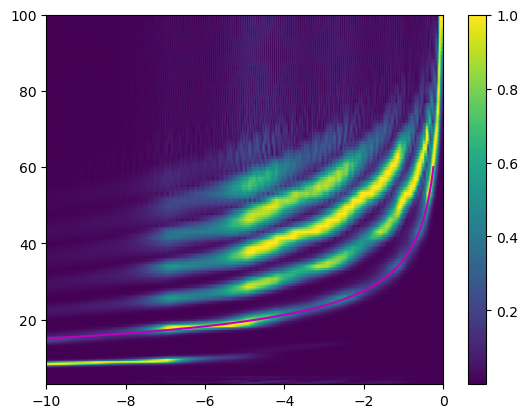

In [4]:
# Make qtransform plot
plt.pcolormesh(h_q_times, h_q_freqs, h_q_amp)
plt.colorbar()

# Plot frequency track
plt.plot(t_arr, f_gw, c='m')

# Plot formatting
plt.ylim(3,100)
plt.xlim(-10, 0)

The magenta line here tracks the frequency evolution of our h0 harmonic. Now, let's work out the frequencies of our other harmonics using the frequency of apsidal advance (denoted $f_\textrm{peri}$ here).

In [5]:
# Gets orbital frequency from gravitational wave frequency
def f_orb(f_gw):
    return f_gw/2

# Gets apsidal advance frequency from gravitational wave frequency
def f_peri(f_gw):
    P_orb = 2/f_gw
    e = shifted_e(f_gw, f_low, ecc)
    peri_advance_per_orb = peri_advance_orbit(P_orb, e, M*aconst.M_sun.value)
    P_peri = P_orb*2*np.pi/peri_advance_per_orb
    return 1/P_orb - 1/P_peri

In [6]:
# Parameters
harmonics = np.arange(7)
ecc = 0.2 # defined at f_low
M = chirp2total(10, 2)
f_low = 5
f_high = 60
fs = np.linspace(f_low, f_high, 1001)

In [7]:
# Get how many multiples of f_peri for harmonic k
def f_peri_multiple(k):
    if k < 5:
        return int((k+1)/2)*(2*(k%2)-1)
    else:
        return k-2

# Draw frequency evolution of harmonics
def plot_f_harms(ax, ks, f_gws):

    # Get component of frequencies
    f_orbs = f_orb(f_gws)
    f_peris = f_peri(f_gws)

    # Add and plot frequencies for each harmonic
    for k in ks:
        peri_mult = f_peri_multiple(k)
        f_harms = 2*f_orbs + peri_mult*f_peris
        ax.plot(f_gws, f_harms/f_orbs, label=f'h{k}')

# Plots a dashed line at every integer on the y axis
def plot_int_lines(ax, n):
    if n < 5:
        n = 5
    ints = np.arange(1, n)
    for y_pos in ints:
        plt.axhline(y_pos, c='k', ls='dashed', alpha=0.5, zorder=-1)

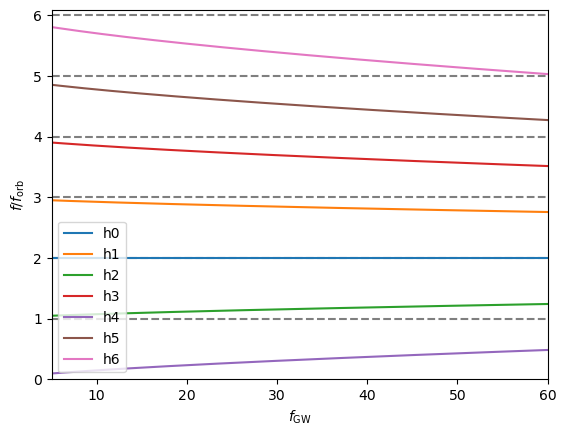

In [8]:
# Make plot
plot_f_harms(plt.gca(), harmonics, fs)
plot_int_lines(plt.gca(), len(harmonics))
plt.xlabel('$f_\mathrm{GW}$')
plt.ylabel('$f$/$f_\mathrm{orb}$')
plt.xlim(f_low, f_high)
plt.ylim(0,)
plt.legend()

Now we can test whether the frequencies in the above plot, or simple integer multiples of the orbital frequency fit the harmonics we see in the qtransform.

In [11]:
# Frequencies of harmonics assuming integer multiples of orbital freq
def int_harm_freqs(f_gws, n):

    # Calculate frequencies
    freqs = []
    for i in range(n):
        if i != 2:
            freqs.append(i*f_gws/2)

    return freqs

# Frequencies of harmonics using apsidal advance frequency
def peri_harm_freqs(f_gws, n):

    # Calculate frequency components
    f_orbs = f_orb(f_gws)
    f_peris = f_peri(f_gws)

    # Calculate frequency for each harmonic
    freqs = []
    for k in range(n):
        if k != 0:
            peri_mult = f_peri_multiple(k)
            f_harms = 2*f_orbs + peri_mult*f_peris
            freqs.append(f_harms)

    return freqs

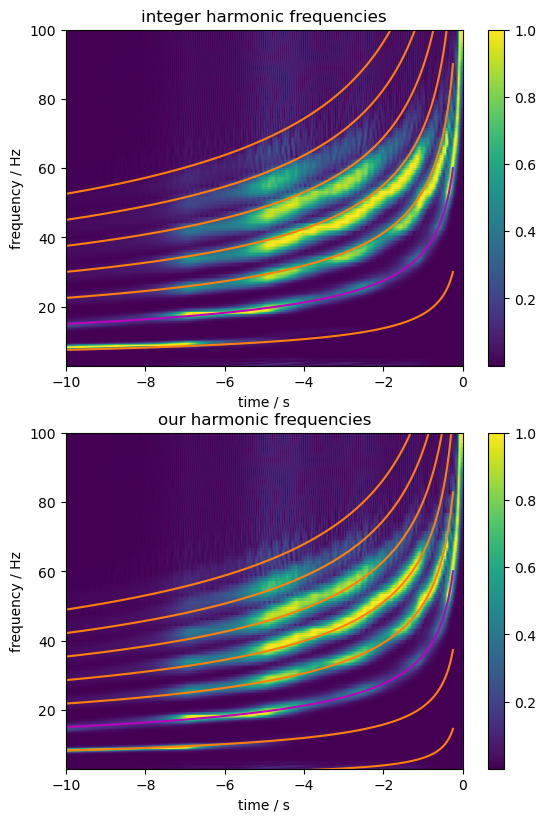

In [15]:
# Subplot settings
harm_funcs = [int_harm_freqs, peri_harm_freqs]
titles = ['integer harmonic frequencies', 'our harmonic frequencies']

# Figure with two subplots
plt.figure(figsize=(6.4,4.8*2))
for i in range(2):
    plt.subplot(2,1,i+1)

    # Make qtransform plot
    plt.pcolormesh(h_q_times, h_q_freqs, h_q_amp)
    plt.colorbar()

    # Plot frequency track
    plt.plot(t_arr, f_gw, c='m')
    
    # Plot harmonic frequency predictions
    harm_freqs = harm_funcs[i](f_gw, 8)
    for harm_freq in harm_freqs:
        plt.plot(t_arr, harm_freq, c='C1')
    
    # Plot formatting
    plt.title(titles[i])
    plt.ylim(3,100)
    plt.xlim(-10, 0)
    plt.xlabel('time / s')
    plt.ylabel('frequency / Hz')